In [2]:
import os
import tarfile
from six.moves import urllib

#解压文件
housing_tgz = tarfile.open("./housing.tgz")
housing_tgz.extractall()
housing_tgz.close()

In [3]:
#读取文件
import pandas as pd
housing = pd.read_csv("./housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
#读取信息，发现total_bedrooms中有缺省值
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
#查看最后一列类别型数据共有几个类别
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
#查看数据分布
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


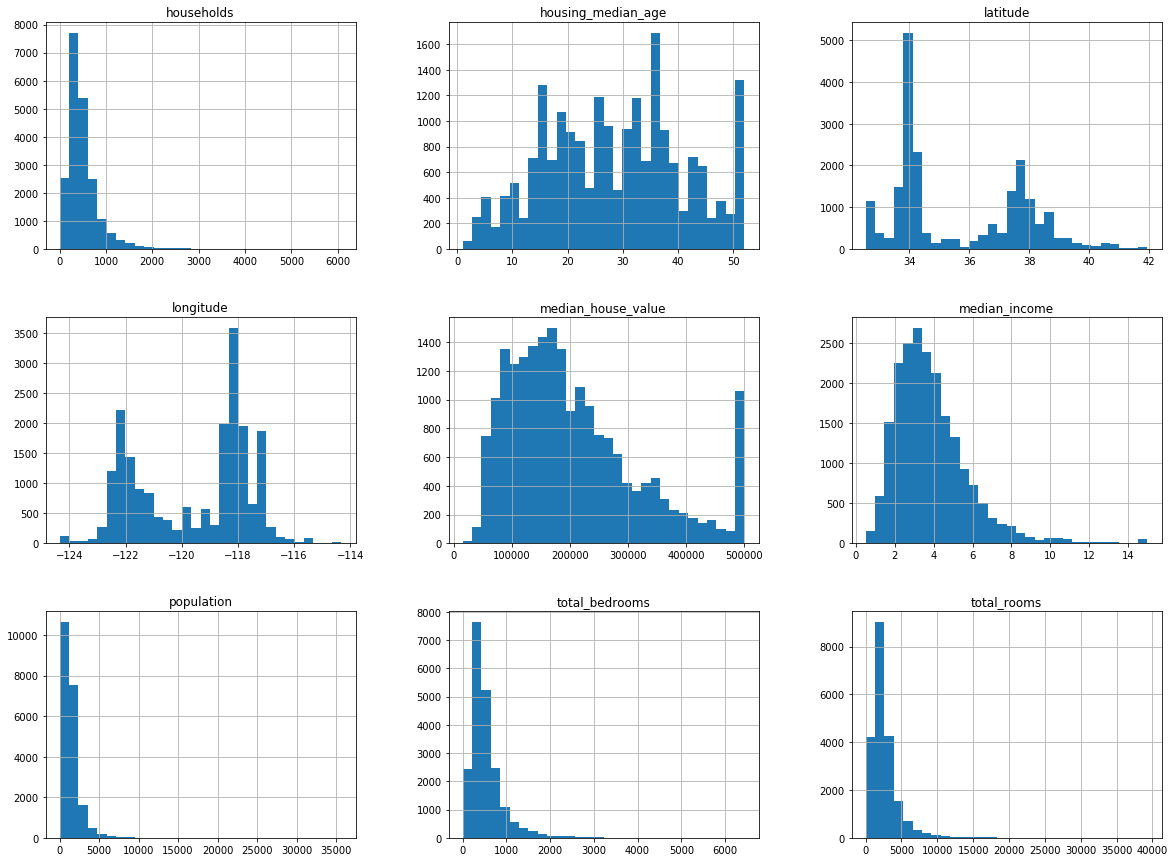

In [7]:
#绘制直方图
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=30,figsize=(20,15))
plt.show()

In [8]:
#分割数据集train和test
import numpy as np
def split_train_test(data,test_ratio):
    shuffled_indices = np.random.permutation(len(data))  #打乱顺序，需要考虑这个变量不是时序性的
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]

train_set,test_set = split_train_test(housing,0.2)
print(len(train_set),len(test_set))

16512 4128


In [9]:
#上述方法产生的随机数没有指定随机种子，因此每次产生的数都不相同，不可取
#我们换一种方法
import hashlib
def test_set_check(identifier,test_ratio,hash):
    return hash(np.int64(identifier)).digest()[-1]<256*test_ratio  #hash.digest返回摘要，作为二进制数据字符串值

def split_train_test_by_id(data,test_ratio,id_column,hash=hashlib.md5):  #hashlib,md5初始化hash表
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_:test_set_check(id_,test_ratio,hash))
    return data.loc[in_test_set],data.loc[in_test_set]

housing_with_id = housing.reset_index() #重新建立0，1，2...新索引
train_set,test_set = split_train_test_by_id(housing_with_id,0.2,'index')  #没有id只能暂时用index作为识别码

In [10]:
housing_with_id['id'] = housing['longitude']*1000+housing['latitude']  #将纬度和经度结合作为一列新的id
train_set,test_set = split_train_test_by_id(housing_with_id,0.2,'id')

In [11]:
#当然最简单的可以用sklearn中的函数切分数据集
from sklearn.model_selection import train_test_split
train_set,test_set = train_test_split(housing,test_size=0.2,random_state=1127)

In [12]:
#为了保证气氛数据集层次相同，我们对收入进行归类，将收入中位数除以1.5
#同时创建一个收入类别属性，同ceil函数对值进行舍入（以产生离散的分类），然后将所有大于5的分类归入到5
housing['income_cat']=np.ceil(housing['median_income']/1.5)  #ceil函数表示四舍五入
housing['income_cat'].where(housing['income_cat']<5,5.0,inplace=True)  #where函数表示如果不满足条件，那么就执行变换为5.0

In [13]:
#分层切分数据集，保证数据分布不变
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=1127)
for train_index,test_index in split.split(housing,housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

#查看收入分类比例，确保是否符合    
print(housing['income_cat'].value_counts()/len(housing)) #总体
print(strat_train_set['income_cat'].value_counts()/len(strat_train_set)) #层次切分

from sklearn.model_selection import train_test_split
train_set,test_set = train_test_split(housing,test_size=0.2,random_state=1127) 
print(train_set['income_cat'].value_counts()/len(train_set)) #随机切分

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64
3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64
3.0    0.350351
2.0    0.322250
4.0    0.174419
5.0    0.113130
1.0    0.039850
Name: income_cat, dtype: float64


In [14]:
#删除income_cat属性，使数据回到初始状态
for set in (strat_train_set,strat_test_set):
    set.drop(['income_cat'],axis=1,inplace=True)  #axis=1表示在列上做变换

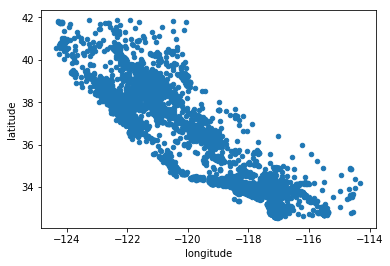

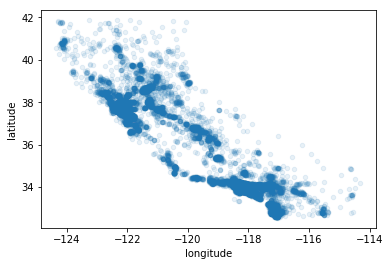

In [15]:
#接下来进行DEA(data explore analysis)
housing = strat_train_set.copy() #拷贝一个副本，以免改变原数据集

housing.plot(kind='scatter',x='longitude',y='latitude') #散点重合的比较厉害，我们修改下透明度在试试
housing.plot(kind='scatter',x='longitude',y='latitude',alpha=0.1)

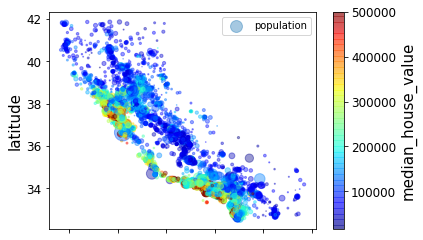

In [16]:
#修改下坐标轴以及颜色，让他看起来更好看
plt.rcParams['axes.labelsize']=15  #reParams表示rc配置各种默认属性
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

housing.plot(kind='scatter',x='longitude',y='latitude',alpha=0.4,
            s=housing['population']/100,label='population',
            c='median_house_value',cmap=plt.get_cmap('jet'),colorbar=True) #这里去除colorbar=True好像也没有影响
plt.legend()
plt.show()  

In [17]:
#从上图可以看出房价和位置和人人口密度关系密切
#下面继续查看每个属性之间的关联度
corr_matrix = housing.corr()

#先看看房价中位数与哪些属性相关：
corr_matrix['median_house_value'].sort_values(ascending=False)
#分析可以看出收入中位数与房价有较强的相关性，同时纬度与房价也有轻微的负相关（即越往北，房价越低）

median_house_value    1.000000
median_income         0.686935
total_rooms           0.132665
housing_median_age    0.106661
households            0.065847
total_bedrooms        0.047877
population           -0.024941
longitude            -0.043021
latitude             -0.147024
Name: median_house_value, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """


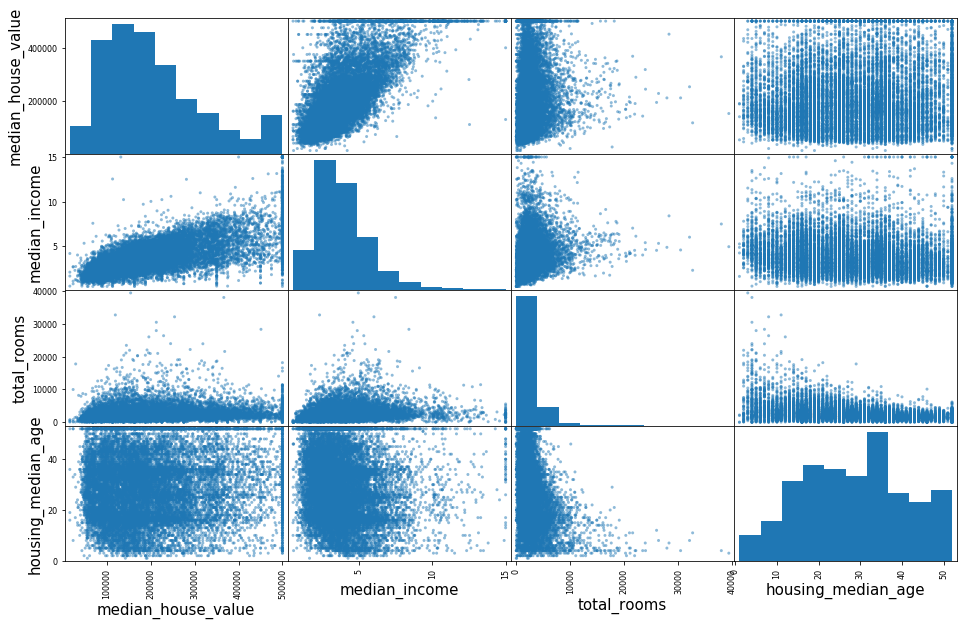

In [18]:
#另一种检测属性相关系数的方法
from pandas.tools.plotting import scatter_matrix
#由于scatter_matrix能画出每个属性对所有属性的图，即有11**2=121张，所以只关注最相关的几个属性
attributes = ['median_house_value','median_income','total_rooms','housing_median_age']  
scatter_matrix(housing[attributes],figsize=(16,10))
plt.show()

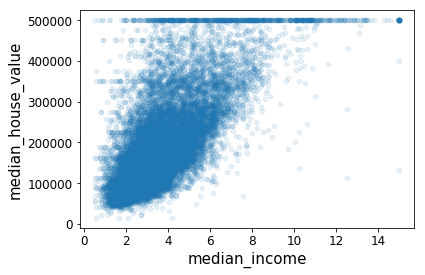

In [19]:
#从上图可以看出最有希望预测房价的是收入，将它放大
housing.plot(kind='scatter',x='median_income',y='median_house_value',alpha=0.1)
plt.show()
#从图中可以看出之前看到的最高价都在500000美元这条线上，还有不明显的是450000、350000、28000都有一条线，因此我们在进行学习时要对它做相关的处理

In [20]:
#以上是数据的可视化探索，下面开始生成一些特征属性
housing['rooms_per_household']=housing['total_rooms']/housing['households']  #每个户有几个房间
housing['bedrooms_per_room']=housing['total_bedrooms']/housing['total_rooms'] #每户卧室与总房间的比值
housing['population_per_household']=housing['population']/housing['households'] #每户有几口人

#看看先关系数
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)
#可以看出新造的特征bedroomd_per_room与median_house_value的相关的更高，非常好

median_house_value          1.000000
median_income               0.686935
rooms_per_household         0.144534
total_rooms                 0.132665
housing_median_age          0.106661
households                  0.065847
total_bedrooms              0.047877
population_per_household   -0.022428
population                 -0.024941
longitude                  -0.043021
latitude                   -0.147024
bedrooms_per_room          -0.253471
Name: median_house_value, dtype: float64

In [21]:
#将data和label进行分离
housing = strat_train_set.drop('median_house_value',axis=1)
housing_label = strat_train_set['median_house_value'].copy()

In [22]:
#数据清洗，对前面含有缺失值的特征进行处理
housing.dropna(subset=['total_bedrooms']) #第一种删除含有缺失值的行
housing.drop('total_bedrooms',axis=1) #第二种是直接删除该列
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median)  #第三是将中位数填充值缺失值

7067      290.0
8110      195.0
18157     578.0
12153     941.0
488       604.0
6969      413.0
12959    1106.0
3653      429.0
14140     508.0
19221     603.0
9741     1000.0
2934      266.0
6545      317.0
15034     163.0
84        184.0
4380      555.0
13259    1796.0
16972     321.0
11951     320.0
12338    1035.0
2597      565.0
3749      568.0
10057     275.0
17016     355.0
6953      370.0
2416      489.0
3147     1692.0
9178      852.0
2870      359.0
8439      116.0
          ...  
10010     254.0
9754      583.0
5599      561.0
7514      232.0
4860      478.0
2124      303.0
12486     804.0
17760     610.0
17349     354.0
5338      648.0
9085     1555.0
2346      496.0
13680     786.0
19767     277.0
18891     524.0
19470     124.0
4498      258.0
17324     585.0
12835     526.0
15091     538.0
11382     383.0
3921      435.0
17434     301.0
4874      284.0
1707      349.0
18000     309.0
4243      464.0
6842      572.0
6736      276.0
3546     1653.0
Name: total_bedrooms, Le

In [23]:
#sklearn中提供处理缺失值的函数为imputer
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='median') #用中位数填充缺失值

#只有数值型的才能算出中位数，先创建一份不包括文本属性ocean_proximity的数据副本
housing_num = housing.drop('ocean_proximity',axis=1)
#现在imputer计算出了每个属性的中位数，并将结果保存至imputer的属性statistics_中
imputer.fit(housing_num)
#查看下每个属性的中位数
print(imputer.statistics_)
print(housing_num.median().values)
#将训练的imputer对训练集进行转换
X=imputer.transform(housing_num)

[-118.49     34.26     29.     2131.      435.     1170.      410.
    3.5341]
[-118.49     34.26     29.     2131.      435.     1170.      410.
    3.5341]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [24]:
#X转换后为一个numpy数组，我们将其转换为dataframe看看
housing_tr = pd.DataFrame(X,columns=housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-118.01,33.95,36.0,1579.0,290.0,816.0,276.0,4.4318
1,-118.20,33.79,47.0,767.0,195.0,569.0,195.0,2.9514
2,-122.06,37.37,32.0,2510.0,578.0,1160.0,581.0,4.9087
3,-117.25,33.70,10.0,5156.0,941.0,2294.0,747.0,3.5800
4,-122.26,37.86,52.0,2888.0,604.0,1253.0,538.0,3.3893


In [25]:
#将前面的ocean_proximity转换为数值型特征
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 4, 0, ..., 0, 0, 0])

In [26]:
#注意：上述文本转化是错误的,label_encoder只能转换标签，前面使用没出错是因为只有一列文本特征值,应用多个文本时应该使用factorize
housing_cat_encoded,housing_catrgories=housing_cat.factorize()
housing_cat_encoded[:10]
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [27]:
#上面将文本转换为有序的数值不符合原意，我们将其转换为one-hot编码
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [28]:
housing_cat_1hot.toarray() #housing_cat_1hot是一个稀疏的矩阵，将其转化为一个numpy观察

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [29]:
#使用labelbinarizer也可以执行上述转换
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot 

array([[1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [30]:
#上述转换方式同样是错误的，原因和前面一样，都是应用于标签列的转换，正确的是用CatrgoricalEncoder进行转换,这个转换需要在sklearn 0.21版本中才会实现
# from sklearn.preprocessing import CategoricalEncoder
# cat_encoder = CategoricalEncoder()
# housing_cat_reshaped = housing_cat.values.reshape(-1,1)
# housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
# housing_cat_1hot

In [31]:
#利用transformerminxin自定义一个转化器
from sklearn.base import BaseEstimator,TransformerMixin
rooms_ix,bedrooms_ix,population_ix,household_ix=3,4,5,6
class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    def __init__(self,add_bedrooms_per_room=True):
        self.add_bedrooms_per_room=add_bedrooms_per_room
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        rooms_per_household=X[:,rooms_ix]/X[:,household_ix]
        population_per_household = X[:,population_ix]/X[:,household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix]/X[:,rooms_ix]
            return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household,population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs=attr_adder.transform(housing.values)

In [32]:
#算上特征缩放，我们将这些转换建立一个流水线
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([('imputer',Imputer(strategy='median')),
                         ('attribs_adder',CombinedAttributesAdder()),
                         ('std_scaler',StandardScaler())])
housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


array([[ 0.77750503, -0.78637248,  0.58392317, ...,  0.11534962,
        -0.01238856, -0.45533063],
       [ 0.68260092, -0.86133181,  1.45779444, ..., -0.59191321,
        -0.01571439,  0.60465778],
       [-1.24545093,  0.81588329,  0.2661518 , ..., -0.43888125,
        -0.09515821,  0.24482777],
       ...,
       [ 0.71756559, -0.73483794, -0.92549083, ..., -0.95420385,
        -0.02594484,  1.7984388 ],
       [ 0.73255045, -0.70204323,  1.45779444, ...,  1.25132341,
        -0.01892006, -1.35819968],
       [ 0.47281289, -0.64113877, -1.08437651, ...,  0.56955653,
        -0.03945271, -0.92768554]])

In [33]:
#定义一个将dataframe转化为numpy格式的转换器
from sklearn.base import BaseEstimator,TransformerMixin
class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names=attribute_names
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return X[self.attribute_names].values

In [34]:
#下面是一个完整的流水线，增加了对文本数据的处理,最后使用featureunion连接
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

from sklearn.pipeline import FeatureUnion
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']
num_pipeline = Pipeline([
    ('selector',DataFrameSelector(num_attribs)),
    ('imputer',Imputer(strategy='median')),
    ('attribs_adder',CombinedAttributesAdder()),
    ('std_scaler',StandardScaler()),
    ])

cat_pipeline = Pipeline([
    ('selector',DataFrameSelector(cat_attribs)),
    ('cat_encoder',OneHotEncoder(sparse=False)),  #sparse=false表示返回数组，否则默认返回稀疏矩阵
    ])

full_pipeline = FeatureUnion(transformer_list=[('num_pipeline',num_pipeline),('cat_pipeline',cat_pipeline)])
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


array([[ 0.77750503, -0.78637248,  0.58392317, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.68260092, -0.86133181,  1.45779444, ...,  0.        ,
         0.        ,  1.        ],
       [-1.24545093,  0.81588329,  0.2661518 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.71756559, -0.73483794, -0.92549083, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.73255045, -0.70204323,  1.45779444, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.47281289, -0.64113877, -1.08437651, ...,  0.        ,
         0.        ,  0.        ]])

In [37]:
#选择模型训练,先试试线性回归
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_label)
some_data = housing.iloc[:5]
some_labels = housing_label.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print(lin_reg.predict(some_data_prepared))
print(list(some_labels))

[241823.15778517 212347.38839869 308498.99229972 172182.40094122
 246125.91913528]
[181100.0, 185200.0, 322700.0, 113400.0, 241700.0]


In [39]:
#计算均方误差
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_label,housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68050.25377075102

In [41]:
#上述可以看出线性回归表现欠拟合，因此我们换决策树进行训练
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared,housing_label)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_label,housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [46]:
#上面我们用训练集训练的模型去预测训练集，以此得到没有误差，是一种过拟合线性，我们改为交叉验证
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg,housing_prepared,housing_label,scoring='neg_mean_squared_error',cv=10)
rmse_scores = np.sqrt(-scores)
def display_scores(scores):
    print(scores,scores.mean(),scores.std())

display_scores(rmse_scores)

[67581.21528383 73435.88019526 71298.13836207 71208.12524442
 71726.18268401 71744.58315977 69765.63410038 69787.3098999
 68886.41057571 70037.10286695] 70547.05823722885 1586.5905087822125


In [50]:
#上述可以看出决策树训练结果并不理想，因此我们换随机森林进行尝试
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared,housing_label)
scores = cross_val_score(forest_reg,housing_prepared,housing_label,scoring='neg_mean_squared_error',cv=10)
rmse_scores = np.sqrt(-scores)
display_scores(rmse_scores)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[53548.95915392 54297.73319344 51139.22476068 54488.27009988
 54274.17448016 52697.9016585  50325.28775037 49583.32424698
 52628.64110994 54895.08497626] 52787.860143012964 1774.39184263659


In [51]:
#随机森林比前两个效果都要好，我们可以对超参数进行微调
from sklearn.model_selection import GridSearchCV
param_grid=[
    {'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
    {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]}
    ]
grid_search = GridSearchCV(forest_reg,param_grid,cv=5,scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared,housing_label)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [52]:
#得到最好参数
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [53]:
#最好的模型为
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [54]:
#cv_results_的正确打开方式
cvres = grid_search.cv_results_
for mean_score,params in zip(cvres['mean_test_score'],cvres['params']):
    print(np.sqrt(-mean_score),params)

63793.222201529126 {'max_features': 2, 'n_estimators': 3}
55239.34051384508 {'max_features': 2, 'n_estimators': 10}
52583.13065668952 {'max_features': 2, 'n_estimators': 30}
59106.99414642202 {'max_features': 4, 'n_estimators': 3}
52490.27603647846 {'max_features': 4, 'n_estimators': 10}
50266.05537988579 {'max_features': 4, 'n_estimators': 30}
58987.113865775566 {'max_features': 6, 'n_estimators': 3}
52086.21662575844 {'max_features': 6, 'n_estimators': 10}
49989.45336113923 {'max_features': 6, 'n_estimators': 30}
59082.88252781303 {'max_features': 8, 'n_estimators': 3}
51719.92235081092 {'max_features': 8, 'n_estimators': 10}
50179.56249914521 {'max_features': 8, 'n_estimators': 30}
62173.83396741657 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54020.27606854358 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59946.03325584894 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52208.587886711124 {'bootstrap': False, 'max_features': 3, 'n_estimators':

In [56]:
#还可以通过分析最佳模型，指出每个属性对预测的重要度
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.08135325, 0.07534795, 0.04045051, 0.01847995, 0.01623861,
       0.01705024, 0.01530994, 0.32346213, 0.05915576, 0.10551521,
       0.06748945, 0.01458842, 0.15387871, 0.00033515, 0.00417722,
       0.00716751])

In [61]:
#把重要性与属性名放在一起
extra_attribs = ['rooms_per_hhold','pop_per_hhold','bedrooms_per_room']
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs+extra_attribs+cat_one_hot_attribs
sorted(zip(feature_importances,attributes),reverse=True)

[(0.32346212645713285, 'median_income'),
 (0.15387870632289838, 'INLAND'),
 (0.10551520905775509, 'pop_per_hhold'),
 (0.08135325478857718, 'longitude'),
 (0.07534794583190543, 'latitude'),
 (0.06748945129585429, 'bedrooms_per_room'),
 (0.0591557560489373, 'rooms_per_hhold'),
 (0.04045051132023738, 'housing_median_age'),
 (0.018479951689910897, 'total_rooms'),
 (0.017050242494263654, 'population'),
 (0.016238607555580774, 'total_bedrooms'),
 (0.015309935396742802, 'households'),
 (0.014588420173919028, '<1H OCEAN'),
 (0.0071675073940282805, 'NEAR OCEAN'),
 (0.004177222037978778, 'NEAR BAY'),
 (0.0003351521342779038, 'ISLAND')]

In [63]:
#上面可以看出那些重要度较高，同时可以删除重要度低的
#下面我们最终评估测试集
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop('median_house_value',axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared=full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test,final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48891.75205780187

In [68]:
#最后还可以将训练好的模型进行存储
full_pipeline_with_predictor=Pipeline([
    ('preparation',full_pipeline),
    ('froest_reg',forest_reg)])
full_pipeline_with_predictor.fit(housing,housing_label)
full_pipeline_with_predictor.predict(some_data)

my_model= full_pipeline_with_predictor
from sklearn.externals import joblib
joblib.dump(my_model,'my_model.pkl')
my_model_loaded = joblib.load('my_model.pkl')